In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import f1_score

### Pre-processing for Random Forest

In [3]:
df = pd.read_csv('C:/Users/sudha/Downloads/data.csv')
df.head()

,A53_M5_3007 (Belegungen/Intervall),D11 (Belegungen/Intervall),D12 (Belegungen/Intervall),D21 (Belegungen/Intervall),D31 (Belegungen/Intervall),D41 (Belegungen/Intervall),D42 (Belegungen/Intervall),H53_M3_3006 (Belegungen/Intervall),H53_M6_1140 (Belegungen/Intervall),H57_M1_1137 (Belegungen/Intervall),Date,Time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06,00:00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2021-01-06,00:01:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06,00:02:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-01-06,00:03:00
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2021-01-06,00:04:00


#### Creating one single DateTime column and taking hourly_sum of data

In [4]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('Datetime', inplace=True)
hourly_sum = df.resample('H').sum()

In [ ]:
hourly_sum.reset_index(inplace=True)
hourly_sum.fillna(0, inplace=True)
print(hourly_sum)

#### Speficying the training and target variables and performing test-train split

In [6]:
hourly_sum['Year'] = hourly_sum['Datetime'].dt.year
hourly_sum['Month'] = hourly_sum['Datetime'].dt.month
hourly_sum['Day'] = hourly_sum['Datetime'].dt.day
hourly_sum['Hour'] = hourly_sum['Datetime'].dt.hour

In [7]:
X = hourly_sum[['Year', 'Month', 'Day', 'Hour']]
y = hourly_sum['D42 (Belegungen/Intervall)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}
#tsc

results = {}


# Loop through each combination of hyperparameters
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for max_features in param_grid['max_features']:
                    for bootstrap in param_grid['bootstrap']:
                # Create and train the model with the current hyperparameters
                        rf_model = RandomForestRegressor(
                            n_estimators=n_estimators,
                            max_depth=max_depth,
                            min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,
                            max_features = max_features,
                            bootstrap = bootstrap,
                            random_state=42
                        )
                        rf_model.fit(X_train, y_train)
                
                        # Make predictions on the test set
                        y_pred = rf_model.predict(X_test)
                
                        # Calculate mean squared error and store the results
                        mse = mean_squared_error(y_test, y_pred)
                        results[(n_estimators, max_depth, min_samples_split, min_samples_leaf,max_features,bootstrap)] = mse




In [10]:
best_params_dict = {
    'n_estimators': best_params[0],
    'max_depth': best_params[1],
    'min_samples_split': best_params[2],
    'min_samples_leaf': best_params[3],
    'max_features' : best_params[4],
    'bootstrap': best_params[5],
    'random_state': 42
}
best_rf_model = RandomForestRegressor(**best_params_dict)

In [12]:
print(best_params)

(100, None, 2, 1, 'sqrt', False)


In [13]:
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', random_state=42)

In [14]:
# Make predictions on the test data
y_pred = best_rf_model.predict(X_test)

In [33]:
# Convert predicted values to integers if needed
print(y_pred)
y_pred_int = np.round(y_pred).astype(int)
print(y_pred_int)
total_prediction = len(y_pred_int)
true_cut = pd.cut(y_test, bins=3, labels=[0, 1,2])

pred_cut = pd.cut(y_pred_int, bins=3, labels=[0, 1,2])
# Count the number of correctly predicted labels
correct_predictions = np.sum(pred_cut == true_cut)

# Calculate the accuracy (percentage of correct predictions)
accuracy = correct_predictions / len(true_cut) * 100

# Print or use the results as needed
print(f"Number of Correct Predictions: {correct_predictions} out of {total_prediction}")
print(f"Accuracy: {accuracy:.2f}%")


f1 = f1_score(true_cut, pred_cut, average=None)
print("F1 Score:", f1)

[ 25.04  10.85 387.75 ...   0.     0.     0.  ]
[ 25  11 388 ...   0   0   0]
Number of Correct Predictions: 2568 out of 7661
Accuracy: 33.52%
F1 Score: [0.54081525 0.00301659 0.00702576]


#### Evaluation metrics

In [34]:
# MAE
mae = mean_absolute_error(true_cut, pred_cut)
r2 = r2_score(true_cut, pred_cut)
y_test = np.where(true_cut == 0, 1e-100, true_cut)
mean_actual = sum(true_cut) / len(true_cut)  # Calculate the mean of actual values
mae_percentage = (mae / mean_actual) * 100


# SMAPE
y_true_ar, y_pred_arr = np.array(true_cut).astype('float64'), np.array(pred_cut).astype('float64')
numerator = np.abs(y_pred_arr - y_true_ar)
denominator = (np.abs(y_true_ar) + np.abs(y_pred_arr)) / 2.0
percentage_errors = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
smape_score = np.mean(percentage_errors) * 100

print(f"Mean Absolute Error: {mae}")
print(f"R2: {r2:.2f}")
print(f"MAE as Percentage: {mae_percentage:.2f}%")
print(f"SMAPE Score: {smape_score:.2f}%")

mape = mean_absolute_percentage_error(true_cut, pred_cut)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error: 0.8981856154549015
R2: -1.05
MAE as Percentage: 89.83%
SMAPE Score: 119.80%
Mean Absolute Percentage Error (MAPE): 0.62%


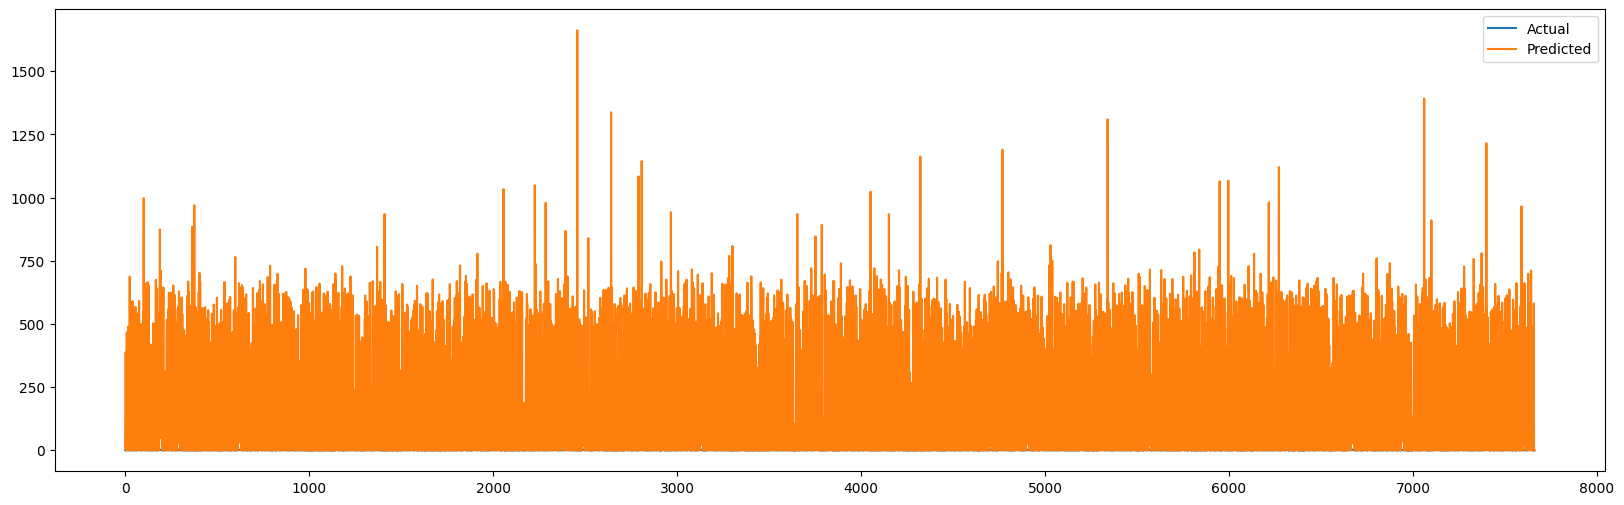

In [35]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

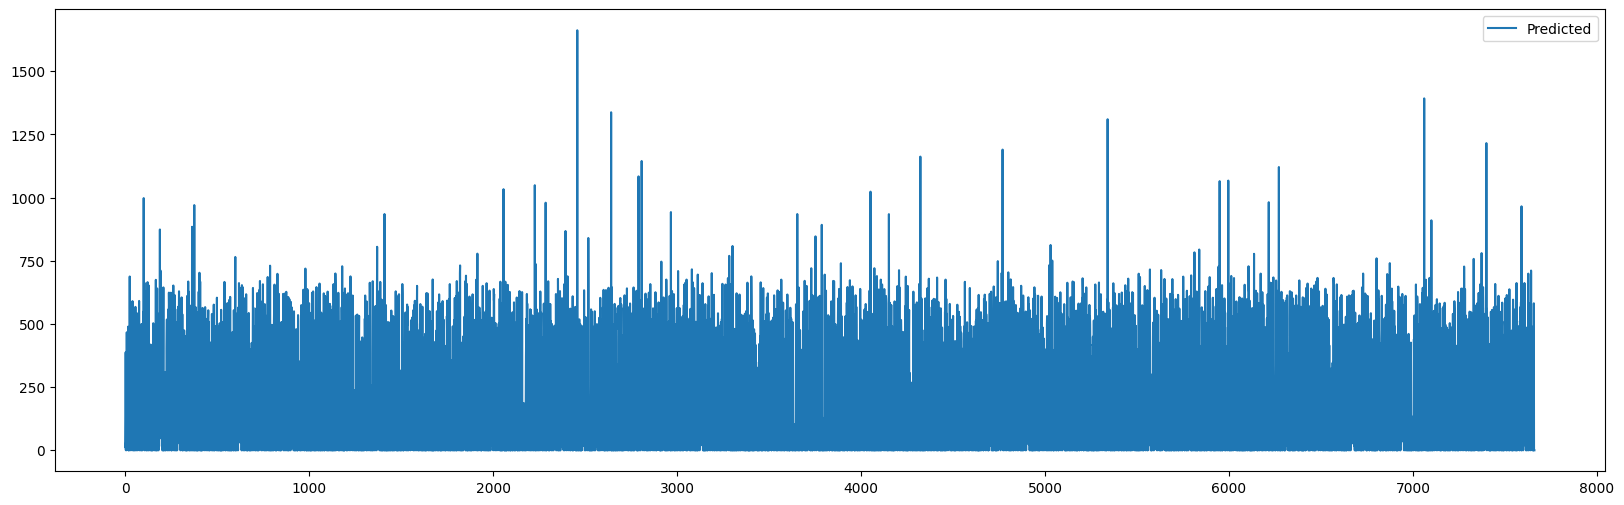

In [36]:
plt.figure(figsize=(20, 6))

plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

